<h1 align=center><font color=royalblue><b> Optimal Distribution Network for BB Ice Company in North York, Ontario </b></font></h1>

## Table of Contents -

<div class="alert alert-block alert-info" style="margin-top: 20px"> 

<font size = 4>
    
1. <a href="#item1">Introduction</a><br><br>
    
2. <a href="#item2">Data Requirement and Data Collection</a><br><br>
    
3. <a href="#item3">Data Wrangling</a><br><br>

4. <a href="#item4">Model Preparation and Evaluation</a><br><br>
    
5. <a href="#item5">Result</a><br><br>

</font>   

</div>

<a id='item1'></a>

## Introduction

After their huge success in Sydney, an Australian startup “BB Ice Company” decided to expand their business overseas. As one of the founding members of this company was from North York, Ontario, Canada they decided to set up their manufacturing and distribution center there. There is a saying - “Ice is the equivalent to a stove for a chef”. Heat, and Cold, both change every aspect of the final product.

The company makes crystal clear ice which is in demand at many restaurants, bars, pubs, diners, lounges, and nightclubs serving drinks like liquor, cocktails, and mocktails. The temperature affects how the drink feels, by numbing the taste buds. They say that a big cube of perfectly clear, hand-cut ice, is clearly the perfect serve, and won’t overly dilute the drink. Also, cooler temperatures can smooth an average liquor by rounding its edges. 

The company wants to make an optimal distribution network in North York to achieve the timely delivery of Ice pops/cubes/slabs to their potential customers. For this, the stakeholders want to segment all the presumable targets into clusters and then assign each cluster a cold storage truck for better and efficient delivery. We will cluster the venues based on their GPS coordinates and then will create an information chart for each cluster and map those clusters on North York Map so that the stakeholders can make informed decisions.


#### Install all the important library packages

<div class="alert alert-block alert-info" style="margin-top: 20px">When doing interactive computing it is common to need to access the underlying shell. This is doable through the use of the exclamation mark ! (or bang). Be sure to provide "-y" to specify yes to the install prompt as you can not submit input to the commands when running.
</div>

In [1]:
# uncomment if installation required

#!conda install -c anaconda beautifulsoup4 -y
#!conda install -c anaconda lxml -y
#!conda install -c conda-forge geopy -y
#!pip install folium
#!pip install pgeocode
print('All libraries installed successfully.')

All libraries installed successfully.


#### Import required library packages

In [2]:
import pandas as pd # library for data manipulation and analysis
import numpy as np # library for multi-dimensional arrays and matrices
import urllib.request # the library we use to open URLs
from bs4 import BeautifulSoup # the BeautifulSoup library so we can parse HTML and XML documents
import requests # library to handle requests
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import pgeocode # library for high performance off-line querying of GPS coordinates
import folium #Map rendering library
from sklearn.cluster import KMeans #import k-means for clustering stage
from sklearn.metrics import silhouette_score #import silhouette_score for k-means model evaluation
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


<a id='item2'></a>

## Data Requirement and Data Collection

- We will need a list of all the neighborhoods in North York, Ontario, Canada. The list can be extracted from the Wikipedia Page “List of postal codes of Canada: M” having URL:https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M. For web scraping, we will use the beautifulsoup4 Python package and for data wrangling, we will use the Pandas Python package.

- We will also need the GPS coordinates of each neighborhood. For this, we will use the PGeoCoder package that can give the query results based on postal codes.

- We also need the list of all the pubs, bars, restaurants, nightclubs, diner, and lounge for each neighborhood within the radius of 1.5kms. This data will be extracted from FourSquare Server using FourSquare APIs.


Now we will specify the URL of the Wikipedia page we are looking to scrape and then using the urllib.request library, we want to query the page and put the HTML data into a variable (which we have called ‘url’). Next we want to import the functions from Beautiful Soup which will let us parse and work with the HTML we fetched from our Wiki page. Then we use Beautiful Soup to parse the HTML data we stored in our ‘url’ variable and store it in a new variable called ‘soup’ in the Beautiful Soup format.

In [3]:
# specify which URL/web page we are going to be scraping
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
# open the url using urllib.request and put the HTML into the page variable
page = urllib.request.urlopen(url)
# parse the HTML from our URL into the BeautifulSoup parse tree format
soup = BeautifulSoup(page, "lxml")
#print(soup.prettify()) #uncomment this line to view the webpage in HTML


We know the required data resides within an HTML table tag with class = 'wikitable sortable' after inspecting the elements of Wikipedia webpage using F12 key.

In [4]:
table=soup.find('table', class_='wikitable sortable')
#table #uncomment this to see the table data

We know that the table is set up in rows (starting with <*tr*> tags) with the data sitting within <*td*> tags in each row. We aren’t too worried about the header row with the <*th*> elements as we know what each of the columns represent by looking at the table. There are three columns in our table that we want to scrape the data from so we will set up three empty lists (postal_code, borough & neighborhood) to store our data in.

To start with, we want to use the Beautiful Soup ‘find_all’ function again and set it to look for the string ‘tr’. We will then set up a FOR loop for each row within that array and set Python to loop through the rows, one by one.

Within the loop we are going to use find_all again to search each row for <*td*> tags with the ‘td’ string. We will add all of these to a variable called ‘cells’ and then check to make sure that there are 3 items in our ‘cells’ array (i.e. one for each column).

If there are then we use the find(text=True)) option to extract the content string from within each <*td*> element in that row and add them to the lists we created at the start of this step. 

In [5]:
postal_code=[]
borough=[]
neighborhood=[]

for row in table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==3:
        postal_code.append(cells[0].find(text=True))
        borough.append(cells[1].find(text=True))
        neighborhood.append(cells[2].find(text=True))

We will create a dataframe with pandas, assigning each of the lists into a column with the name of our source table columns i.e. PostalCode, Borough, and Neighborhood.

In [6]:
headers = [postal_code, borough,neighborhood]
columns=['PostalCode','Borough','Neighborhood']
df_postal_m=pd.DataFrame(headers).transpose() 
df_postal_m.columns = columns
df_postal_m.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


<a id='item3'></a>

## Data Wrangling

Now all the necessary steps for Data Wrangling will be performed. Like removing regex, whitespace, NaN values, duplicates, etc.

In [7]:
df_postal_m=df_postal_m.replace('\n',' ', regex=True) #remove regular expression '\n' from the dataframe cells
df_postal_m=df_postal_m.apply(lambda x: x.str.strip()) #remove the whitespace character from the dataframe cells
df_postal_m.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [8]:
df_postal_m=df_postal_m.replace('Not assigned',np.NaN) # Replace 'Not assigned' with NaN
df_postal_m.isna().sum() #Total Nan values for each column in DataFrame

PostalCode       0
Borough         77
Neighborhood    77
dtype: int64

In [9]:
df_postal_m.dropna(subset=["Borough"],inplace=True) #Removing all rows having 'Borough' value as NaN.
df_postal_m.reset_index(inplace=True,drop=True)
df_postal_m.head(12)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


Now we will extraxt the rows having North York as their Borough value and make a new DataFrame df_NorthYork.

In [10]:
df_NorthYork = df_postal_m.groupby(['Borough']).get_group('North York').reset_index(drop=True)


In [11]:
df_NorthYork.head()


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M6A,North York,"Lawrence Manor, Lawrence Heights"
3,M3B,North York,Don Mills
4,M6B,North York,Glencairn


In [12]:
list_postalcodes = list(df_NorthYork['PostalCode'])

In [13]:
list_postalcodes[:5]

['M3A', 'M4A', 'M6A', 'M3B', 'M6B']

#### Data Collection for GPS coordinates

We will use the pgeocode library package for querying the GPS coordinates based on postal codes.

In [14]:
nomi = pgeocode.Nominatim('ca') #ca is country code for canada
df_ll= nomi.query_postal_code(list_postalcodes) #querying all the postal codes in postal_list and saving the result DataFrame in df_postal_ll.
df_ll.head()

,postal_code,country code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,M3A,CA,North York (York Heights / Victoria Village / ...,Ontario,ON,North York,NaN,NaN,NaN,43.7545,-79.3300,1.0
1,M4A,CA,North York (Sweeney Park / Wigmore Park),Ontario,ON,NaN,NaN,NaN,NaN,43.7276,-79.3148,6.0
2,M6A,CA,North York (Lawrence Manor / Lawrence Heights),Ontario,ON,North York,NaN,NaN,NaN,43.7223,-79.4504,6.0
3,M3B,CA,Don Mills North,Ontario,ON,Don Mills,NaN,NaN,NaN,43.7450,-79.3590,4.0
4,M6B,CA,North York (Glencairn),Ontario,ON,North York,NaN,NaN,NaN,43.7081,-79.4479,6.0


Merging the two dataframes.

In [15]:
df1 = df_NorthYork
df2 = df_ll[['latitude','longitude']]
df_list = [df1,df2]
df_merged = pd.concat(df_list,axis=1)

In [16]:
df_merged.rename(columns={"latitude": "Latitude", "longitude": "Longitude"}, inplace=True)

In [17]:
df_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.7545,-79.3300
1,M4A,North York,Victoria Village,43.7276,-79.3148
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504
3,M3B,North York,Don Mills,43.7450,-79.3590
4,M6B,North York,Glencairn,43.7081,-79.4479


Lets now Visualize all the neighborhoods on the Map of North York, Ontario. First we will extract the GPS Coordinates of North York. In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>foursquare_agent</em>, as shown below.

In [18]:
address = 'North York,ON'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of North York are- Latitude {}, Longitude {}.'.format(latitude, longitude))


The geograpical coordinate of North York are- Latitude 43.7543263, Longitude -79.44911696639593.


#### North York Map with all the Neighborhoods Marked.

In [19]:
# create map of North York,Ontario using latitude and longitude values and showing all neighborhoods
map_northyork = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for borough, neighborhood,lat, lng, in zip(df_merged['Borough'], df_merged['Neighborhood'],
                                           df_merged['Latitude'], df_merged['Longitude']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#FFA500',
        fill_opacity=0.8,
        parse_html=False).add_to(map_northyork)  
    
map_northyork

Now we will get the latitude and the longitude coordinates of each neighborhood which is required for FourSquare API calls. We will assign the Foursquare ID and Secret to variable CLIENT_ID and CLIENT_SECRET. The version we will use is 20200501. Also we will define some functions to make our work easy.

In [20]:

def foursquare_explore (postal_code_list, neighborhood_list, lat_list, lng_list, LIMIT = 500, radius = 1500):
    result_ds = []
 
    for postal_code, neighborhood, lat, lng in zip(postal_code_list, neighborhood_list, lat_list, lng_list):
         
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, 
            lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]['items']
        dict_temp = {}
        dict_temp['PostalCode'] = postal_code; 
        dict_temp['Neighborhood'] = neighborhood; 
        dict_temp['Latitude'] = lat;
        dict_temp['Longitude'] = lng;
        dict_temp['Result'] = results;
        result_ds.append(dict_temp)
     
        
    return result_ds;

In [21]:
# The code was removed by Watson Studio for sharing.

Now we will run the fourquare_explore function on each neighborhood and create a new dataframe called NY_Foursquare_Dataset.

In [22]:
# Retriving data from foursquare api 

NY_Foursquare_Dataset = foursquare_explore(list(df_merged['PostalCode']),list(df_merged['Neighborhood']),
                           list(df_merged['Latitude']),list(df_merged['Longitude']),)

In [23]:
#NY_Foursquare_Dataset[0]

In [24]:
#extract details from foursquare dataset and save in dataframe

def get_venue_dataset(foursquare_dataset):
    result_df = pd.DataFrame(columns = ['PostalCode', 'Neighborhood', 
                                           'N_Latitude', 'N_Longitude','Venue_id',
                                          'Venue', 'Venue_Category', 'V_Latitude' , 'V_Longitude'])
    
    
    for neigh_dict in foursquare_dataset:
        postal_code = neigh_dict['PostalCode']; 
        neigh = neigh_dict['Neighborhood']
        lat = neigh_dict['Latitude']; 
        lng = neigh_dict['Longitude']
    
        for venue_dict in neigh_dict['Result']:
            name = venue_dict['venue']['name']
            vlat = venue_dict['venue']['location']['lat']
            vlng = venue_dict['venue']['location']['lng']
            cat =  venue_dict['venue']['categories'][0]['name']
            vid = venue_dict['venue']['id']
            
            result_df = result_df.append({'PostalCode': postal_code, 'Neighborhood': neigh, 
                              'N_Latitude': lat, 'N_Longitude':lng,'Venue_id':vid,
                              'Venue': name,'Venue_Category': cat, 'V_Latitude': vlat ,'V_Longitude': vlng }, 
                                ignore_index = True)
            
    return result_df


In [25]:
df_NY = get_venue_dataset(NY_Foursquare_Dataset)

Let us have a look at the shape of the Dataset.

In [26]:
df_NY.shape

(1205, 9)

In [27]:
df_NY.head()

,PostalCode,Neighborhood,N_Latitude,N_Longitude,Venue_id,Venue,Venue_Category,V_Latitude,V_Longitude
0,M3A,Parkwoods,43.7545,-79.33,4b8991cbf964a520814232e3,Allwyn's Bakery,Caribbean Restaurant,43.759840,-79.324719
1,M3A,Parkwoods,43.7545,-79.33,4bd4846a6798ef3bd0c5618d,Donalda Golf & Country Club,Golf Course,43.752816,-79.342741
2,M3A,Parkwoods,43.7545,-79.33,4e8d9dcdd5fbbbb6b3003c7b,Brookbanks Park,Park,43.751976,-79.332140
3,M3A,Parkwoods,43.7545,-79.33,4b8ec91af964a520053733e3,Graydon Hall Manor,Event Space,43.763923,-79.342961
4,M3A,Parkwoods,43.7545,-79.33,4b149ea4f964a52029a523e3,Darband Restaurant,Middle Eastern Restaurant,43.755194,-79.348498


Now we will look at the list of unique venue categories and then extract the ones relevant for our model like pub, bar, restaurant etc.

In [28]:
set(df_NY['Venue_Category'])

{'Accessories Store',
 'Airport',
 'American Restaurant',
 'Antique Shop',
 'Argentinian Restaurant',
 'Art Gallery',
 'Arts & Crafts Store',
 'Asian Restaurant',
 'Athletics & Sports',
 'Auto Garage',
 'Automotive Shop',
 'BBQ Joint',
 'Baby Store',
 'Bagel Shop',
 'Bakery',
 'Bank',
 'Bar',
 'Baseball Field',
 'Basketball Court',
 'Beer Store',
 'Bike Shop',
 'Bookstore',
 'Botanical Garden',
 'Boutique',
 'Bowling Alley',
 'Breakfast Spot',
 'Bridal Shop',
 'Bubble Tea Shop',
 'Building',
 'Burger Joint',
 'Burrito Place',
 'Bus Line',
 'Bus Station',
 'Bus Stop',
 'Butcher',
 'Cafeteria',
 'Café',
 'Camera Store',
 'Cantonese Restaurant',
 'Caribbean Restaurant',
 'Cheese Shop',
 'Chinese Restaurant',
 'Chocolate Shop',
 'Climbing Gym',
 'Clothing Store',
 'Coffee Shop',
 'Community Center',
 'Convenience Store',
 'Cosmetics Shop',
 'Creperie',
 'Deli / Bodega',
 'Department Store',
 'Dessert Shop',
 'Dim Sum Restaurant',
 'Diner',
 'Discount Store',
 'Dog Run',
 'Dumpling Restaura

In [29]:
#Extracting rows having relevant venue category.

df_drinks = df_NY[(df_NY['Venue_Category'].str.match('Pub')) | (df_NY['Venue_Category'].str.match('Bar')) 
                | (df_NY['Venue_Category'].str.match('Lounge')) | (df_NY['Venue_Category'].str.match('Nightclub'))
                | (df_NY['Venue_Category'].str.contains('Restaurant')) | (df_NY['Venue_Category'].str.match('Diner'))].reset_index(
            drop=True)


In [30]:
df_drinks.shape

(310, 9)

In [31]:
df_drinks.head()

,PostalCode,Neighborhood,N_Latitude,N_Longitude,Venue_id,Venue,Venue_Category,V_Latitude,V_Longitude
0,M3A,Parkwoods,43.7545,-79.3300,4b8991cbf964a520814232e3,Allwyn's Bakery,Caribbean Restaurant,43.759840,-79.324719
1,M3A,Parkwoods,43.7545,-79.3300,4b149ea4f964a52029a523e3,Darband Restaurant,Middle Eastern Restaurant,43.755194,-79.348498
2,M3A,Parkwoods,43.7545,-79.3300,58a8dcaa6119f47b9a94dc05,A&W,Fast Food Restaurant,43.760643,-79.326865
3,M3A,Parkwoods,43.7545,-79.3300,4bfc6313d6f2c9b6e9264fc8,China Gourmet,Chinese Restaurant,43.755189,-79.348382
4,M4A,Victoria Village,43.7276,-79.3148,550df684498ea2dd2c87bb5a,Jatujak,Thai Restaurant,43.736208,-79.307668


In [32]:
# Total for each kind of category
df_drinks['Venue'].value_counts()

McDonald's                                          9
KFC                                                 7
Thai Express                                        6
Harvey's                                            5
Burger King                                         5
A&W                                                 4
Congee Queen 皇后名粥                                   4
Swiss Chalet                                        4
Wimpy's Diner                                       3
Wendy’s                                             3
Windfields Restaurant                               2
Jerusalem Restaurant                                2
Kwan Dim Sum                                        2
Viet House                                          2
The Captain's Boil                                  2
Euro Shawarma                                       2
Goose & Firkin                                      2
The Miller Tavern                                   2
Pyung Won House             

#### Now we will visualize total number of venues per neighborhood using a Bar Graph.

In [33]:
#Making a Dataframe with neighborhoods and their corresposnding total venues.

df_bar= df_drinks.groupby('Neighborhood').count().sort_values(by='Venue',ascending=False)
df_bar[['Venue']]

,Venue
Neighborhood,
Don Mills,46
"Willowdale, Willowdale East",38
"Bedford Park, Lawrence Manor East",26
"Willowdale, Newtonbrook",26
"Lawrence Manor, Lawrence Heights",23
Downsview,19
Glencairn,19
"Northwood Park, York University",17
"Fairview, Henry Farm, Oriole",15


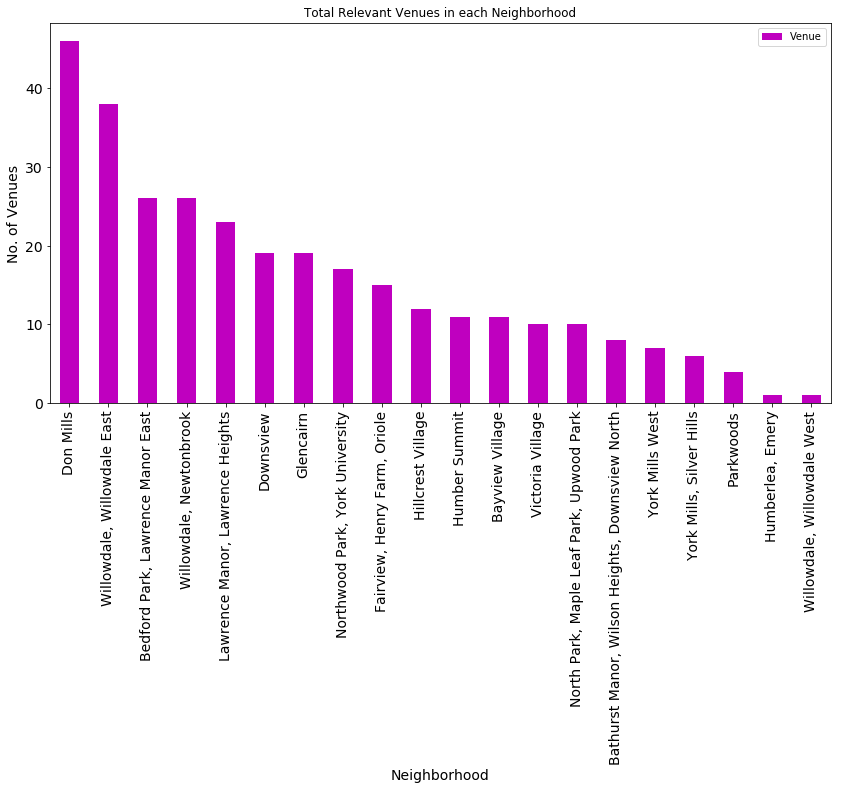

In [34]:
df_bar[['Venue']].plot(kind='bar', figsize=(14,7), color='m', fontsize=14)
plt.xlabel('Neighborhood',fontsize=14)
plt.ylabel('No. of Venues',fontsize=14)
plt.title('Total Relevant Venues in each Neighborhood')
plt.show()

#### Also let us mark all the relevant venues on the Map of North York

In [35]:
map_NY_V = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers to map
for lat, lng, label in zip(df_drinks['V_Latitude'], df_drinks['V_Longitude'], df_drinks['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 2,
        popup = label,
        color ='#b300b3',
        parse_html=False).add_to(map_NY_V) 
    
    
map_NY_V

<a id='item4'></a>

## Model Preparation and Evaluation

Now we will segment these venues into cluster using unsupervised clustering algorithm called Kmeans clustering. Kmeans algorithm is an iterative algorithm that tries to partition the dataset into Kpre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to only one group. It tries to make the intra-cluster data points as similar as possible while also keeping the clusters as different (far) as possible. It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster’s centroid (arithmetic mean of all the data points that belong to that cluster) is at the minimum. The less variation we have within clusters, the more homogeneous (similar) the data points are within the same cluster. K-Means algorithm is one of the most common clustering method of unsupervised learning. 

We will make different models using different values of **k** and then to evaluate all the models and select the best value of k for our model we will use - 

1. Elbow Method 
2. Silhouette Coefficient

In [36]:
df_drinks_ll=df_drinks[['V_Latitude','V_Longitude']]
sil = []
K =  range(2,20)
for k in K:
    kmeans = KMeans(n_clusters=k,random_state=2).fit(df_drinks_ll)
    label = kmeans.labels_
    sil.append(silhouette_score(df_drinks_ll, label, metric='euclidean'))
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(k, sil[k-2]))

For n_clusters=2, The Silhouette Coefficient is 0.5037042739244834
For n_clusters=3, The Silhouette Coefficient is 0.49103492892898537
For n_clusters=4, The Silhouette Coefficient is 0.5327495271940919
For n_clusters=5, The Silhouette Coefficient is 0.4986612328610187
For n_clusters=6, The Silhouette Coefficient is 0.503369557461169
For n_clusters=7, The Silhouette Coefficient is 0.5077634259877206
For n_clusters=8, The Silhouette Coefficient is 0.5125382996639394
For n_clusters=9, The Silhouette Coefficient is 0.5113779654121413
For n_clusters=10, The Silhouette Coefficient is 0.5111867273543333
For n_clusters=11, The Silhouette Coefficient is 0.5254201604666275
For n_clusters=12, The Silhouette Coefficient is 0.5212398456754436
For n_clusters=13, The Silhouette Coefficient is 0.5659984133306576
For n_clusters=14, The Silhouette Coefficient is 0.5824655183003131
For n_clusters=15, The Silhouette Coefficient is 0.577276314186421
For n_clusters=16, The Silhouette Coefficient is 0.578121

We want the Silhoutte coefficients to be as big as possible and close to 1 to have a good cluster. Lets check the maximum value of coefficient.

In [37]:
max(sil)


0.584806565023008

Lets make a line chart to visualize the Silhouette score for each value of k in range 2 to 20.

#### Silhouette Coefficient

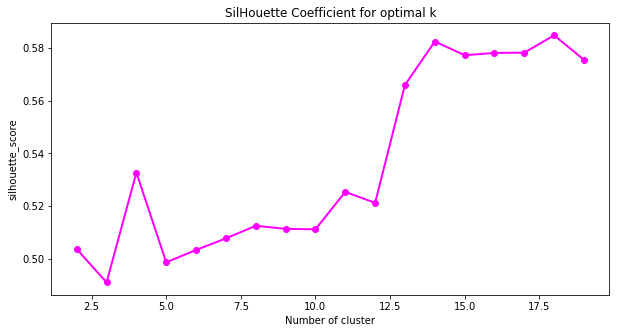

In [38]:

plt.figure(figsize=(10,5))
plt.plot(K, sil, linewidth=2, color='magenta', marker='o', ms=6)
plt.xlabel("Number of cluster")
plt.ylabel("silhouette_score")
plt.title('SilHouette Coefficient for optimal k')
plt.show()

Here we can see that k=14 and k=18 are both good candidates for the optimum value of k. As there isn't much difference between the score of both ks we will select the k=14 for cost-efficient distribution.

In [39]:
sum_of_squared_distances = []
for k in K:
    k_means = KMeans(n_clusters=k,random_state=2).fit(df_drinks_ll)
    sum_of_squared_distances.append(k_means.inertia_)
    print("For n_clusters={}, Sum of squared distances is {}".format(k, sum_of_squared_distances[k-2]))

For n_clusters=2, Sum of squared distances is 0.5536797519546948
For n_clusters=3, Sum of squared distances is 0.3225939987112276
For n_clusters=4, Sum of squared distances is 0.20815255775246433
For n_clusters=5, Sum of squared distances is 0.1620110832706726
For n_clusters=6, Sum of squared distances is 0.12479817179975727
For n_clusters=7, Sum of squared distances is 0.10133674852564267
For n_clusters=8, Sum of squared distances is 0.08548825942915143
For n_clusters=9, Sum of squared distances is 0.07176813479614935
For n_clusters=10, Sum of squared distances is 0.062081611736503145
For n_clusters=11, Sum of squared distances is 0.05261649340107652
For n_clusters=12, Sum of squared distances is 0.04481010331164038
For n_clusters=13, Sum of squared distances is 0.0382494796153376
For n_clusters=14, Sum of squared distances is 0.03366178580116248
For n_clusters=15, Sum of squared distances is 0.030079772100402392
For n_clusters=16, Sum of squared distances is 0.027907187627452694
For 

#### Elbow Method

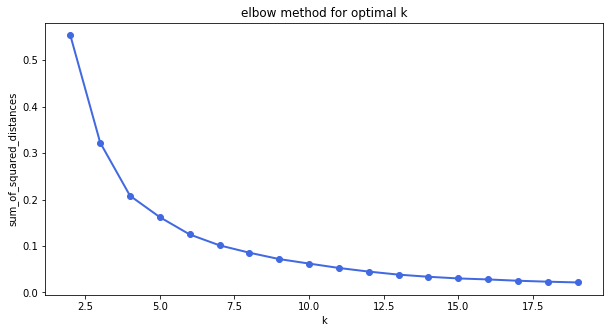

In [40]:
plt.figure(figsize=(10,5))
plt.plot(K, sum_of_squared_distances, linewidth=2, color='royalblue', marker='o', ms=6)
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('elbow method for optimal k')
plt.show()

Here the curve is monotonically decreasing and does not show any elbow or has an obvious point where the curve starts flattening out. But looking closely, we can see that after k=14 the curve slope is almost flat. So, k=14 is a good choice.

#### Making a model for the value of k =14

In [41]:
## set number of clusters
kcluster = 14

# run k-means clustering
kmean14 = KMeans(n_clusters=kcluster, random_state=2).fit(df_drinks_ll)
label14 = kmean14.labels_ #Extract the labels
sse = kmean14.inertia_
sc= silhouette_score(df_drinks_ll, label14, metric='euclidean')

# check cluster labels generated for each row in the dataframe
label14[:5]

array([11,  1, 11,  1,  6], dtype=int32)

In [42]:
print('Sum of squared distances is {} and  The Silhouette Coefficient is {}'.format(sse,sc))

Sum of squared distances is 0.03366178580116248 and  The Silhouette Coefficient is 0.5824655183003131


Now we will assign the extracted labels from the Kmeans model to our df_drinks dataframe by making a new column named Cluster_Label.

In [43]:
df_drinks['Cluster_Label']=label14

In [44]:
df_drinks.head()

,PostalCode,Neighborhood,N_Latitude,N_Longitude,Venue_id,Venue,Venue_Category,V_Latitude,V_Longitude,Cluster_Label
0,M3A,Parkwoods,43.7545,-79.3300,4b8991cbf964a520814232e3,Allwyn's Bakery,Caribbean Restaurant,43.759840,-79.324719,11
1,M3A,Parkwoods,43.7545,-79.3300,4b149ea4f964a52029a523e3,Darband Restaurant,Middle Eastern Restaurant,43.755194,-79.348498,1
2,M3A,Parkwoods,43.7545,-79.3300,58a8dcaa6119f47b9a94dc05,A&W,Fast Food Restaurant,43.760643,-79.326865,11
3,M3A,Parkwoods,43.7545,-79.3300,4bfc6313d6f2c9b6e9264fc8,China Gourmet,Chinese Restaurant,43.755189,-79.348382,1
4,M4A,Victoria Village,43.7276,-79.3148,550df684498ea2dd2c87bb5a,Jatujak,Thai Restaurant,43.736208,-79.307668,6


#### Now we will visualize Total Venues assigned to each Cluster.

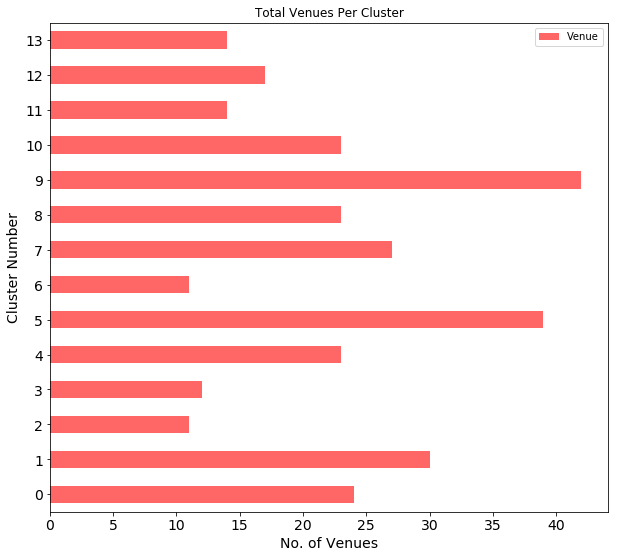

In [45]:
df_cluster_bar = df_drinks.groupby('Cluster_Label').count()
df_cluster_bar[['Venue']].plot(kind='barh', figsize=(10,9), color='#ff6666', fontsize=14)
plt.xlabel('No. of Venues',fontsize=14)
plt.ylabel('Cluster Number',fontsize=14)
plt.title('Total Venues Per Cluster')
plt.show()

Also, it will be very useful to find out the total of each Venue_Category assigned to each cluster. We will first make a Dataframe grouped by Cluster_Label and extract each group and then replace the venue categories having word 'Restaurant' in it with 'Restaurant' like Chinese Restaurant or India Restaurant will be replaced by Restaurant. Then we will make a new DataFrame grouped by Venue Category and find the count for each Category for that cluster. This process will be repeated for each cluster label.

In [46]:
df_cluster0 = df_drinks.groupby('Cluster_Label').get_group(0).reset_index(drop=True)
df_cluster0['Venue_Category']= df_cluster0['Venue_Category'].apply(lambda x: 'Restaurant' if 'Restaurant' in x else x)
df_vCat_cluster0 = df_cluster0.groupby('Venue_Category').count().sort_values(by='Venue',ascending=False)
df_vCat_cluster0[['Venue']]

,Venue
Venue_Category,
Restaurant,24


In [47]:
df_cluster1 = df_drinks.groupby('Cluster_Label').get_group(1).reset_index(drop=True)
df_cluster1['Venue_Category']= df_cluster1['Venue_Category'].apply(lambda x: 'Restaurant' if 'Restaurant' in x else x)
df_vCat_cluster1 = df_cluster1.groupby('Venue_Category').count().sort_values(by='Venue',ascending=False)
df_vCat_cluster1[['Venue']]

,Venue
Venue_Category,
Restaurant,25
Diner,2
Pub,2
Bar,1


In [48]:
df_cluster2 = df_drinks.groupby('Cluster_Label').get_group(2).reset_index(drop=True)
df_cluster2['Venue_Category']= df_cluster2['Venue_Category'].apply(lambda x: 'Restaurant' if 'Restaurant' in x else x)
df_vCat_cluster2 = df_cluster2.groupby('Venue_Category').count().sort_values(by='Venue',ascending=False)
df_vCat_cluster2[['Venue']]

,Venue
Venue_Category,
Restaurant,11


In [49]:
df_cluster3 = df_drinks.groupby('Cluster_Label').get_group(3).reset_index(drop=True)
df_cluster3['Venue_Category']= df_cluster3['Venue_Category'].apply(lambda x: 'Restaurant' if 'Restaurant' in x else x)
df_vCat_cluster3 = df_cluster3.groupby('Venue_Category').count().sort_values(by='Venue',ascending=False)
df_vCat_cluster3[['Venue']]

,Venue
Venue_Category,
Restaurant,11
Nightclub,1


In [50]:
df_cluster4 = df_drinks.groupby('Cluster_Label').get_group(4).reset_index(drop=True)
df_cluster4['Venue_Category']= df_cluster4['Venue_Category'].apply(lambda x: 'Restaurant' if 'Restaurant' in x else x)
df_vCat_cluster4 = df_cluster4.groupby('Venue_Category').count().sort_values(by='Venue',ascending=False)
df_vCat_cluster4

,PostalCode,Neighborhood,N_Latitude,N_Longitude,Venue_id,Venue,V_Latitude,V_Longitude,Cluster_Label
Venue_Category,,,,,,,,,
Restaurant,23,23,23,23,23,23,23,23,23


In [51]:
df_cluster5 = df_drinks.groupby('Cluster_Label').get_group(5).reset_index(drop=True)
df_cluster5['Venue_Category']= df_cluster5['Venue_Category'].apply(lambda x: 'Restaurant' if 'Restaurant' in x else x)
df_vCat_cluster5 = df_cluster5.groupby('Venue_Category').count().sort_values(by='Venue',ascending=False)
df_vCat_cluster5[['Venue']]

,Venue
Venue_Category,
Restaurant,38
Pub,1


In [52]:
df_cluster6 = df_drinks.groupby('Cluster_Label').get_group(6).reset_index(drop=True)
df_cluster6['Venue_Category']= df_cluster6['Venue_Category'].apply(lambda x: 'Restaurant' if 'Restaurant' in x else x)
df_vCat_cluster6 = df_cluster6.groupby('Venue_Category').count().sort_values(by='Venue',ascending=False)
df_vCat_cluster6[['Venue']]

,Venue
Venue_Category,
Restaurant,10
Diner,1


In [53]:
df_cluster7 = df_drinks.groupby('Cluster_Label').get_group(7).reset_index(drop=True)
df_cluster7['Venue_Category']= df_cluster7['Venue_Category'].apply(lambda x: 'Restaurant' if 'Restaurant' in x else x)
df_vCat_cluster7 = df_cluster7.groupby('Venue_Category').count().sort_values(by='Venue',ascending=False)
df_vCat_cluster7[['Venue']]

,Venue
Venue_Category,
Restaurant,22
Pub,4
Diner,1


In [54]:
df_cluster8 = df_drinks.groupby('Cluster_Label').get_group(8).reset_index(drop=True)
df_cluster8['Venue_Category']= df_cluster8['Venue_Category'].apply(lambda x: 'Restaurant' if 'Restaurant' in x else x)
df_vCat_cluster8 = df_cluster8.groupby('Venue_Category').count().sort_values(by='Venue',ascending=False)
df_vCat_cluster8[['Venue']]

,Venue
Venue_Category,
Restaurant,21
Bar,1
Pub,1


In [55]:
df_cluster9 = df_drinks.groupby('Cluster_Label').get_group(9).reset_index(drop=True)
df_cluster9['Venue_Category']= df_cluster9['Venue_Category'].apply(lambda x: 'Restaurant' if 'Restaurant' in x else x)
df_vCat_cluster9 = df_cluster9.groupby('Venue_Category').count().sort_values(by='Venue',ascending=False)
df_vCat_cluster9[['Venue']]

,Venue
Venue_Category,
Restaurant,40
Diner,1
Lounge,1


In [56]:
df_cluster10 = df_drinks.groupby('Cluster_Label').get_group(10).reset_index(drop=True)
df_cluster10['Venue_Category']= df_cluster10['Venue_Category'].apply(lambda x: 'Restaurant' if 'Restaurant' in x else x)
df_vCat_cluster10 = df_cluster10.groupby('Venue_Category').count().sort_values(by='Venue',ascending=False)
df_vCat_cluster10[['Venue']]

,Venue
Venue_Category,
Restaurant,23


In [57]:
df_cluster11 = df_drinks.groupby('Cluster_Label').get_group(11).reset_index(drop=True)
df_cluster11['Venue_Category']= df_cluster11['Venue_Category'].apply(lambda x: 'Restaurant' if 'Restaurant' in x else x)
df_vCat_cluster11 = df_cluster11.groupby('Venue_Category').count().sort_values(by='Venue',ascending=False)
df_vCat_cluster11[['Venue']]

,Venue
Venue_Category,
Restaurant,13
Pub,1


In [58]:
df_cluster12 = df_drinks.groupby('Cluster_Label').get_group(12).reset_index(drop=True)
df_cluster12['Venue_Category']= df_cluster12['Venue_Category'].apply(lambda x: 'Restaurant' if 'Restaurant' in x else x)
df_vCat_cluster12 = df_cluster12.groupby('Venue_Category').count().sort_values(by='Venue',ascending=False)
df_vCat_cluster12[['Venue']]

,Venue
Venue_Category,
Restaurant,16
Diner,1


In [59]:
df_cluster13 = df_drinks.groupby('Cluster_Label').get_group(13).reset_index(drop=True)
df_cluster13['Venue_Category']= df_cluster13['Venue_Category'].apply(lambda x: 'Restaurant' if 'Restaurant' in x else x)
df_vCat_cluster13 = df_cluster13.groupby('Venue_Category').count().sort_values(by='Venue',ascending=False)
df_vCat_cluster13[['Venue']]

,Venue
Venue_Category,
Restaurant,13
Diner,1


#### Now we will visualize the total of each Venue_Category in all the clusters formed.

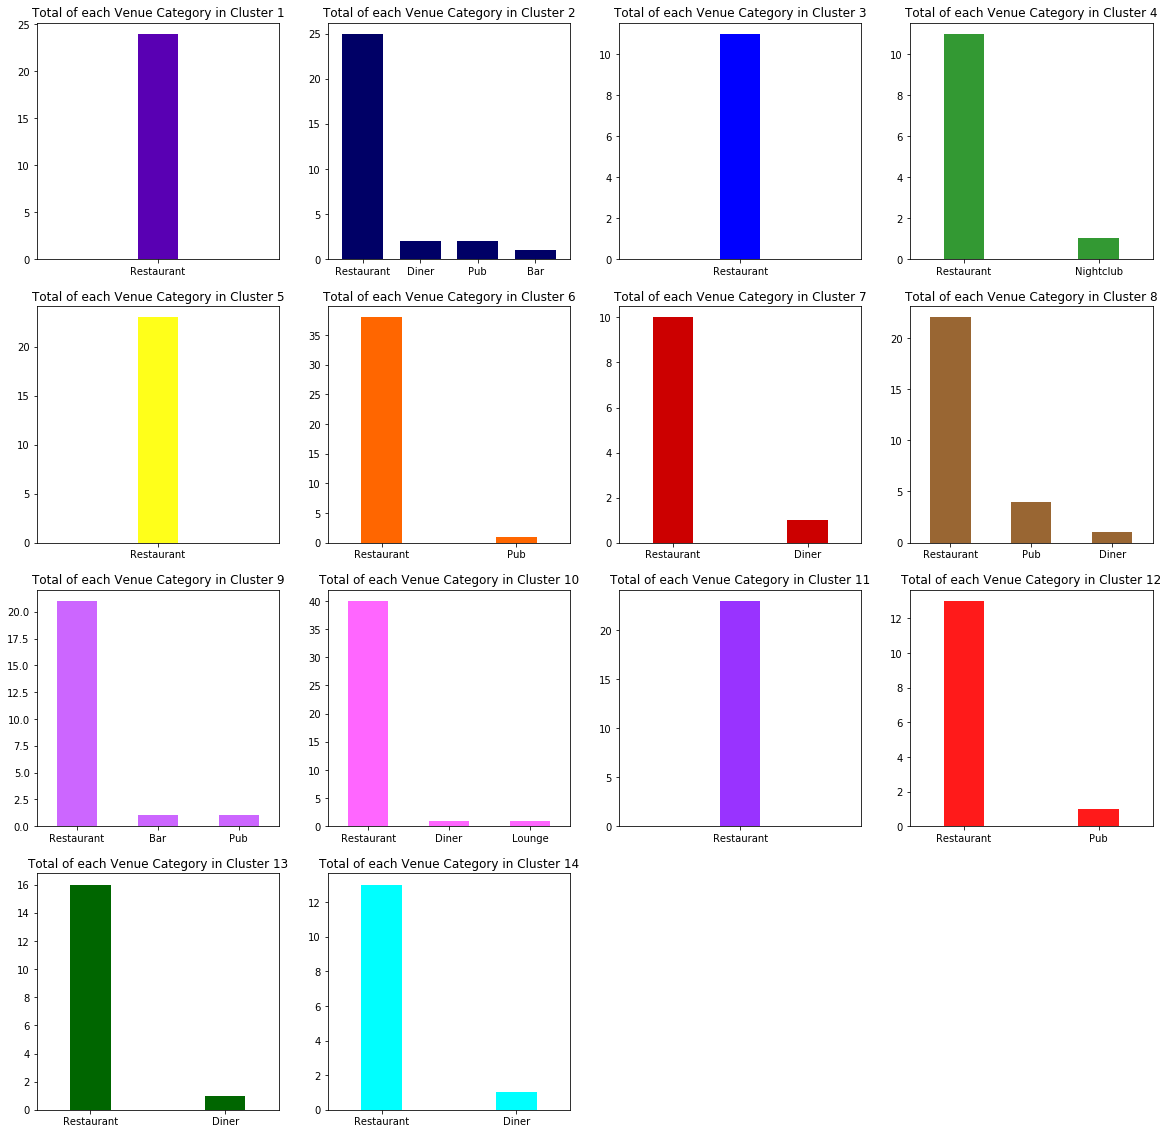

In [60]:
fig = plt.figure(figsize=(20, 20)) # create figure

ax0 = fig.add_subplot(4, 4, 1) 
ax1 = fig.add_subplot(4, 4, 2) 
ax2 = fig.add_subplot(4, 4, 3)
ax3 = fig.add_subplot(4, 4, 4) 
ax4 = fig.add_subplot(4, 4, 5) 
ax5 = fig.add_subplot(4, 4, 6) 
ax6 = fig.add_subplot(4, 4, 7) 
ax7 = fig.add_subplot(4, 4, 8) 
ax8 = fig.add_subplot(4, 4, 9) 
ax9 = fig.add_subplot(4, 4, 10) 
ax10 = fig.add_subplot(4, 4, 11) 
ax11 = fig.add_subplot(4, 4, 12) 
ax12 = fig.add_subplot(4, 4, 13) 
ax13 = fig.add_subplot(4, 4, 14) 

# Subplot 1: Cluster1
df_vCat_cluster0[['Venue']].plot(kind='bar',width=0.1, color='#5900b3',rot=0,legend=False, ax=ax0) # add to subplot 1
ax0.set_title('Total of each Venue Category in Cluster 1')
ax0.set_xlabel('')


# Subplot 2: Cluster2
df_vCat_cluster1[['Venue']].plot(kind='bar',width=0.72, color='#000066',rot=0,legend=False, ax=ax1) # add to subplot 2
ax1.set_title('Total of each Venue Category in Cluster 2')
ax1.set_xlabel('')

# Subplot 3: Cluster3
df_vCat_cluster2[['Venue']].plot(kind='bar',width=0.1, color='#0000ff',rot=0,legend=False, ax=ax2) # add to subplot 3
ax2.set_title('Total of each Venue Category in Cluster 3')
ax2.set_xlabel('')

# Subplot 4: Cluster4
df_vCat_cluster3[['Venue']].plot(kind='bar',width=0.3, color='#339933',rot=0,legend=False, ax=ax3) # add to subplot 4
ax3.set_title('Total of each Venue Category in Cluster 4')
ax3.set_xlabel('')

# Subplot 5: Cluster5
df_vCat_cluster4[['Venue']].plot(kind='bar',width=0.1, color='#ffff1a',rot=0,legend=False, ax=ax4) # add to subplot 5
ax4.set_title('Total of each Venue Category in Cluster 5')
ax4.set_xlabel('')

# Subplot 6: Cluster6
df_vCat_cluster5[['Venue']].plot(kind='bar',width=0.3, color='#ff6600',rot=0,legend=False, ax=ax5) # add to subplot 6
ax5.set_title('Total of each Venue Category in Cluster 6')
ax5.set_xlabel('')

# Subplot 7: Cluster7
df_vCat_cluster6[['Venue']].plot(kind='bar',width=0.3, color='#cc0000',rot=0,legend=False, ax=ax6) # add to subplot 7
ax6.set_title('Total of each Venue Category in Cluster 7')
ax6.set_xlabel('')

# Subplot 8: Cluster8
df_vCat_cluster7[['Venue']].plot(kind='bar', color='#996633',rot=0,legend=False, ax=ax7) # add to subplot 8
ax7.set_title('Total of each Venue Category in Cluster 8')
ax7.set_xlabel('')

# Subplot 9: Cluster9
df_vCat_cluster8[['Venue']].plot(kind='bar', color='#cc66ff',rot=0,legend=False, ax=ax8) # add to subplot 9
ax8.set_title('Total of each Venue Category in Cluster 9')
ax8.set_xlabel('')

# Subplot 10: Cluster10
df_vCat_cluster9[['Venue']].plot(kind='bar', color='#ff66ff',rot=0,legend=False, ax=ax9) # add to subplot 10
ax9.set_title('Total of each Venue Category in Cluster 10')
ax9.set_xlabel('')

# Subplot 11: Cluster11
df_vCat_cluster10[['Venue']].plot(kind='bar',width=0.1, color='#9933ff',rot=0,legend=False, ax=ax10) # add to subplot 11
ax10.set_title('Total of each Venue Category in Cluster 11')
ax10.set_xlabel('')

# Subplot 12: Cluster12
df_vCat_cluster11[['Venue']].plot(kind='bar',width=0.3, color='#ff1a1a',rot=0,legend=False, ax=ax11) # add to subplot 12
ax11.set_title('Total of each Venue Category in Cluster 12')
ax11.set_xlabel('')

# Subplot 13: Cluster13
df_vCat_cluster12[['Venue']].plot(kind='bar',width=0.3, color='#006600',rot=0,legend=False, ax=ax12) # add to subplot 13
ax12.set_title('Total of each Venue Category in Cluster 13')
ax12.set_xlabel('')

# Subplot 14: Cluster14
df_vCat_cluster13[['Venue']].plot(kind='bar',width=0.3, color='#00ffff',rot=0,legend=False, ax=ax13) # add to subplot 14
ax13.set_title('Total of each Venue Category in Cluster 14')
ax13.set_xlabel('')

plt.show()

#### Marking the Clusters on the Map of North York

In [61]:
# Visualize cluster on the map of North York
map_NY_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
colorlist = ['#5900b3','#000066','#0000ff','#339933','#ffff1a','#ff6600',
             '#cc0000','#996633','#cc66ff','#ff66ff','#9933ff','#ff1a1a',
             '#006600','#00ffff']
# add markers to the map
markers_colors = []
for lat, lon, venue, cluster in zip(df_drinks['V_Latitude'], df_drinks['V_Longitude'], df_drinks['Venue'], df_drinks['Cluster_Label']):
    label = folium.Popup(str(venue) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colorlist[cluster-1],
        fill=True,
        fill_color=colorlist[cluster-1],
        fill_opacity=1,
        legend_name='Clusters',
        parse_html=False).add_to(map_NY_clusters)
    
folium.Marker(location=[latitude, longitude], popup="Suitable Site for Bare Bones Ice Company").add_to(map_NY_clusters) 

legend_html = '''
     <div style="position: fixed; bottom: 140px; left: 10px; width: 150px; height: 360px; \
     border:2px solid grey; z-index:9999; font-size:14px;">
     &nbsp; <b>Cluster Legend<b> <br>
     &nbsp; Cluster  1 &nbsp; <i class="fa fa-circle"
                  style="color:#5900b3"></i><br>
     &nbsp; Cluster  2 &nbsp; <i class="fa fa-circle"
                  style="color:#000066"></i><br>
     &nbsp; Cluster  3 &nbsp; <i class="fa fa-circle"
                  style="color:#0000ff"></i><br>
     &nbsp; Cluster  4 &nbsp; <i class="fa fa-circle"
                  style="color:#339933"></i><br>
     &nbsp; Cluster  5 &nbsp; <i class="fa fa-circle"
                  style="color:#ffff1a"></i><br>
     &nbsp; Cluster  6 &nbsp; <i class="fa fa-circle"
                  style="color:#ff6600"></i><br>
     &nbsp; Cluster  7 &nbsp; <i class="fa fa-circle"
                  style="color:#cc0000"></i><br>
     &nbsp; Cluster  8 &nbsp; <i class="fa fa-circle"
                  style="color:#996633"></i><br>
     &nbsp; Cluster  9 &nbsp; <i class="fa fa-circle"
                  style="color:#cc66ff"></i><br>
     &nbsp; Cluster 10 &nbsp; <i class="fa fa-circle"
                  style="color:#ff66ff"></i><br>
     &nbsp; Cluster 11 &nbsp; <i class="fa fa-circle"
                  style="color:#9933ff"></i><br>
     &nbsp; Cluster 12 &nbsp; <i class="fa fa-circle"
                  style="color:#ff1a1a"></i><br>
     &nbsp; Cluster 13 &nbsp; <i class="fa fa-circle"
                  style="color:#006600"></i><br>
     &nbsp; Cluster 14 &nbsp; <i class="fa fa-circle"
                  style="color:#00ffff"></i><br>
     &nbsp; Suitable Site &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:#4dc3ff"></i>
      </div>
     '''
map_NY_clusters.get_root().html.add_child(folium.Element(legend_html))

map_NY_clusters


<a id='item5'></a>

## Result

Using the Kmeans algorithm as part of this clustering study when we evaluated the models using the Elbow method and Silhouette Coefficient, we found the optimum value of k to be 14. So to form the optimal distribution center in the North York the stakeholders can segment the venues and make 14 zones for efficient delivery. Also as they can choose a location near coordinates 43.7615° N, 79.4111° W to set up their manufacturing plant and distribution warehouse as these coordinates are at the center of North York and all the distribution zones would be easily accessible from here. 

Also, it would be best to assign each distribution zone a cold storage truck for the timely and efficient delivery of Ice cubes, pops, and slabs.

Not only for BB Ice company but such a model can be beneficial to many other companies that want to make their distribution network more efficient using similar data analysis and modeling.


###  Thank You!

<div class="alert alert-block alert-success"style="margin-top: 20px"> 
This project is done by Mayank Panwar.

Have a Good Day! :) </div>